In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

Trainset: (1500, 2), Testset: (1500,)


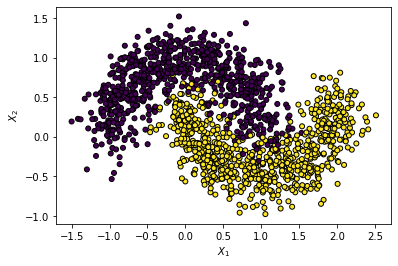

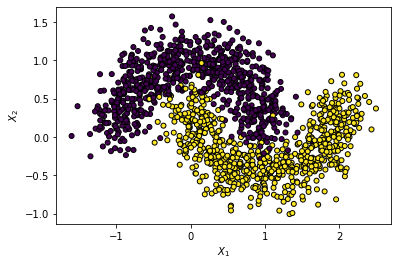

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

#각 모델의 random_state가 같아야함
X, y = make_moons(n_samples=3000, noise=0.2, random_state=42) 
#X, y = make_classification(n_samples=3000, n_features=15,n_informative=10, n_redundant=5,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print("Trainset: {}, Testset: {}".format(X_train.shape, y_train.shape))

plt.scatter(X_train[:, 0], X_train[:, 1], marker='.', c=y_train, s=100,
            edgecolor="k", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, s=100,
            edgecolor="k", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

In [5]:
'''
plt.scatter(X_train[:, 1], X_train[:, 2], marker='.', c=y_train, s=100,
            edgecolor="k", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

plt.scatter(X_train[:, 0], X_train[:, 2], marker='.', c=y_train, s=100,
            edgecolor="k", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()
'''

'\nplt.scatter(X_train[:, 1], X_train[:, 2], marker=\'.\', c=y_train, s=100,\n            edgecolor="k", linewidth=1)\nplt.xlabel("$X_1$")\nplt.ylabel("$X_2$")\nplt.show()\n\nplt.scatter(X_train[:, 0], X_train[:, 2], marker=\'.\', c=y_train, s=100,\n            edgecolor="k", linewidth=1)\nplt.xlabel("$X_1$")\nplt.ylabel("$X_2$")\nplt.show()\n'

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

def get_models(r_state=42, n_est=50, lr=0.1):
    models = dict()
    models['log'] =  LogisticRegression(solver="lbfgs", random_state=42)
    models['sgd']= SGDClassifier(loss="hinge", learning_rate="constant", 
                                 eta0=0.001, max_iter=10000, tol=1e-3, 
                                 random_state=r_state)
    models['dt'] = DecisionTreeClassifier(random_state=r_state)
    models['rf'] = RandomForestClassifier(
                                          random_state=r_state)
    #linear SVM
    models['lsvm'] = SVC(kernel="linear", random_state=r_state)
    #non Linear SVM
    models['polsvm'] = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])
    #Voting
    models['vote'] = VotingClassifier(
        estimators=[('log', models['log']), 
                    ('sgd', models['sgd']), 
                    ('rf', models['rf']), 
                    ('polsvm', models['polsvm'])],
        voting='hard')
    #bagging
    models['bag'] = BaggingClassifier(
        DecisionTreeClassifier(random_state=r_state), n_estimators=n_est,
        bootstrap=True, random_state=r_state)
    
    models['adab'] = AdaBoostClassifier(
        DecisionTreeClassifier(random_state=r_state), n_estimators=n_est,
        algorithm="SAMME.R", learning_rate=lr, random_state=r_state)
    models['grab'] = GradientBoostingClassifier(
        random_state=r_state)

    return models

In [7]:
from sklearn.metrics import accuracy_score
import time

#학습은 train Set 예측은 x_test 값으로 예측
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    elaptime = time.time() - start
    acc = accuracy_score(y_test, y_pred)
    return acc, elaptime

In [8]:
models = get_models()

results, names, times = list(), list(), list()
for name, model in models.items():
    acc, elaptime = evaluate_model(model, X_train, X_test, 
                                   y_train, y_test)
    results.append(acc)
    times.append(elaptime)
    names.append(name)
    print('%s\t %.4f (time: %.3f)' % (name, acc, elaptime))

log	 0.8620 (time: 0.032)
sgd	 0.8607 (time: 0.002)
dt	 0.9620 (time: 0.002)
rf	 0.9700 (time: 0.222)
lsvm	 0.8593 (time: 0.016)
polsvm	 0.9713 (time: 0.004)
vote	 0.9200 (time: 0.233)
bag	 0.9660 (time: 0.115)
adab	 0.9627 (time: 0.003)
grab	 0.9673 (time: 0.120)


In [9]:
from sklearn.ensemble import StackingClassifier

def get_stacking(models, nfold=5):
    layer0 = list()
    layer0.append(('sgd', models['sgd']))
    layer0.append(('vote', models['vote']))
    layer0.append(('rf', models['rf']))
    layer0.append(('grab', models['grab']))
    layer1 = LogisticRegression() #최종 분류
    
    model = StackingClassifier(estimators=layer0,
                              final_estimator=layer1,
                              cv=nfold)
    return model


modelstack = dict()
modelstack['stack'] = get_stacking(models)

results, names, times = list(), list(), list()
for name, model in modelstack.items():
    acc, elaptime = evaluate_model(model, X_train, X_test, 
                                   y_train, y_test)
    results.append(acc)
    times.append(elaptime)
    names.append(name)
    print('%s\t %.4f (time: %.3f)' % (name, acc, elaptime))

stack	 0.9667 (time: 3.212)


In [10]:
def get_stacking2(models, nfold=5):
    layer0 = list()
    layer0.append(('rf', models['rf']))
    layer0.append(('polsvm',  Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ]))
    layer1 = LogisticRegression()
    
    model = StackingClassifier(estimators=layer0,
                              final_estimator=layer1,
                              cv=nfold)
    return model


modelstack = dict()
modelstack['stack2'] = get_stacking2(models)

results, names, times = list(), list(), list()
for name, model in modelstack.items():
    acc, elaptime = evaluate_model(model, X_train, X_test, 
                                   y_train, y_test)
    results.append(acc)
    times.append(elaptime)
    names.append(name)
    print('%s\t %.4f (time: %.3f)' % (name, acc, elaptime))

stack2	 0.9720 (time: 1.119)
